In [3]:
%matplotlib inline 
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader 
from collections import namedtuple

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

Loading the data files:

In [4]:
#Ratings Database File
Ratings = pd.read_csv("ratings.dat", sep = "::", engine = "python", header = None)
Ratings.columns = ["userid","movieid","ratings","timestamp"]
Ratings.head()

,userid,movieid,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
#Movie Database file:
movies = pd.read_csv("movies.dat", sep = "::", header = None, engine = 'python')
movies.columns = ["movieid","title","genres"]
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#User Database file:
users = pd.read_csv("users.dat", sep = "::", header = None, engine = "python")
users.columns = ["userid", "gender", "age", "occupation", "zipcode"]
users.head()

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
n_users = Ratings.userid.unique().shape[0]
n_movies = Ratings.movieid.unique().shape[0]

print ("Total number of users {}".format(n_users))
print("Total number of movies: {}".format(n_movies))

Total number of users 6040
Total number of movies: 3706


Data Processing 

In [8]:
#Removing the timestamp column:
Ratings = Ratings.drop("timestamp", axis = 1)
Ratings.head()

,userid,movieid,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [9]:
movies["genres"] = movies.apply(lambda row : row['genres'].split("|")[0],axis=1)
movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Animation
1,2,Jumanji (1995),Adventure
2,3,Grumpier Old Men (1995),Comedy
3,4,Waiting to Exhale (1995),Comedy
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
movies['movie_year'] = movies.apply(lambda row : int(row['title'].split("(")[-1][:-1]),axis=1)
movies.head()

,movieid,title,genres,movie_year
0,1,Toy Story (1995),Animation,1995
1,2,Jumanji (1995),Adventure,1995
2,3,Grumpier Old Men (1995),Comedy,1995
3,4,Waiting to Exhale (1995),Comedy,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [15]:
movies.drop(["title"], axis = 1, inplace = True)
movie_ratings = pd.merge(Ratings, movies, how = "left", on ="movieid")

KeyError: "['title'] not found in axis"

One hot encoding categorical variables:

In [14]:
users["gender"].replace({"F":0, "M":1}, inplace = True)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [16]:
users["age"].replace({1:0, 18:1, 25:2, 35:3, 45:4, 50:5, 56:6}, inplace = True)

In [17]:
users.drop(["zipcode"], axis = 1, inplace = True)

In [19]:
df = pd.merge(movie_ratings,users, how = "left", on ="userid")

In [20]:
df.head()

,userid,movieid,ratings,genres,movie_year,gender,age,occupation
0,1,1193,5,Drama,1975,0,0,10
1,1,661,3,Animation,1996,0,0,10
2,1,914,3,Musical,1964,0,0,10
3,1,3408,4,Drama,2000,0,0,10
4,1,2355,5,Animation,1998,0,0,10


Defining functions to process the data to train the neural network:

In [21]:
def encoder(df, columns=None):
    if columns == None:
        columns = list(df.select_dtypes(include = ["object"]).columns)

    val_types = dict()
    for i in columns:
        val_types[i] = df[i].unique()

    val_to_ind = dict()
    for x, y in val_types.items():
        val_to_ind[x] = {o: i for i, o in enumerate(val_types[x])}

    for x, y in val_to_ind.items():
        df[x] = df[x].apply(lambda x: y[x])

    return val_to_ind, df

In [23]:
def data_processing(df, wide_cols, embeddings_cols, continuous_cols, target,
    scale=False, def_dim=8):


    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols + continuous_cols
    
    #Creating a temp dataframe
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols ))
    df_temp = df.copy()[all_columns]

    #Extractomg the categorical column names that categorical variable names
    categorical_columns = list(
        df_temp.select_dtypes(include = ["object"]).columns)

    
    encoding_dict,df_temp = encoder(df_temp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict 
                     if k in deep_cols}
    embeddings_input = []
    for x,y in encoding_dict.items():
        embeddings_input.append((x, len(y), emb_dim[x]))

    df_deep = df_temp[deep_cols]
    deep_column_ind = {x:y for y,x in enumerate(df_deep.columns)}


    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1))

    df_wide = df_temp[wide_cols]
    del(df_temp)
    dummy_cols = [c for c in wide_cols if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns = dummy_cols)

    X_train_deep, X_test_deep = train_test_split(
        df_deep.values, test_size = 0.3, random_state=1090)
    X_train_wide, X_test_wide = train_test_split(
        df_wide.values, test_size = 0.3, random_state=1090)
    y_train, y_test = train_test_split(Y, test_size = 0.3, random_state = 1540)

    group_dataset = dict()
    train_dataset = namedtuple("train_dataset", "wide, deep, labels")
    test_dataset  = namedtuple("test_dataset" , "wide, deep, labels")
    group_dataset["train_dataset"] = train_dataset(
        X_train_wide, X_train_deep, y_train)
    group_dataset["test_dataset"]  = test_dataset(
        X_test_wide, X_test_deep, y_test)
    group_dataset["embeddings_input"]  = embeddings_input
    group_dataset["deep_column_ind"] = deep_column_ind
    group_dataset["encoding_dict"] = encoding_dict

    return group_dataset

In [24]:
#Setting up the data
wide_cols = ["movie_year", "gender", "age", "occupation", "genres", "userid", "movieid"]
embeddings_cols = [("genres",20), ("userid",100), ("movieid",100)]
crossed_cols = ()
continuous_cols = ["movie_year","gender","age","occupation"]
target = "ratings"

In [25]:
#Generating the embeddings and getting the training and test splits
pro_data = data_processing(df, wide_cols, embeddings_cols, 
                           continuous_cols, target, scale = True)

In [26]:
pro_data

{'train_dataset': train_dataset(wide=array([[1977,    1,    2, ...,    0,    0,    0],
        [1980,    1,    3, ...,    0,    0,    0],
        [1962,    1,    4, ...,    0,    0,    0],
        ...,
        [1997,    1,    0, ...,    0,    0,    0],
        [1963,    1,    5, ...,    0,    0,    0],
        [1991,    0,    6, ...,    0,    0,    0]], dtype=int64), deep=array([[ 3.00000000e+00,  3.71900000e+03,  2.60000000e+02, ...,
          5.71789879e-01, -1.98771054e-01, -1.07728989e+00],
        [ 0.00000000e+00,  3.32100000e+03,  1.22800000e+03, ...,
          5.71789879e-01,  4.27676718e-01, -1.07728989e+00],
        [ 5.00000000e+00,  2.28100000e+03,  1.20400000e+03, ...,
          5.71789879e-01,  1.05412449e+00,  4.53791252e-01],
        ...,
        [ 4.00000000e+00,  2.75600000e+03,  1.78400000e+03, ...,
          5.71789879e-01, -1.45166660e+00, -6.17965545e-01],
        [ 3.00000000e+00,  9.24000000e+02,  2.94800000e+03, ...,
          5.71789879e-01,  1.68057226e+00,  

In [27]:
use_cuda = torch.cuda.is_available()

#Defining the class for loading the dataset
class DataLoad(Dataset):
    def __init__(self, data):
        
        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels
        
    def __getitem__(self,ind):
        
        xw = self.X_wide[ind]
        xd = self.X_deep[ind]
        y = self.Y[ind]
        
        return xw, xd, y
    def __len__(self):
        return len(self.Y)

#Defining a class for the network architecture

In [28]:
class DNWNet(nn.Module):

    def __init__(self, wide_dim, embeddings_input, continuous_cols, 
                 deep_column_ind, hidden_layers, dropout, 
                 encoding_dict, n_class):

        super(DNWNet, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_ind = deep_column_ind
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class
        self.loss_values=[]

        #Creating embedding layers for the deep part of the network:
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        #Creating the hidden layer for the deep part of the network:
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols),
                                  self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1),
                    nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        #Merging the deep and wide components to the output layer
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim,
                                self.n_class)


    def compile(self, optimizer="SGD", learning_rate=0.001, momentum=0.0):
        
        self.activation, self.criterion = None, F.mse_loss

        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        if optimizer == "RMSprop":
            self.optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)

        self.method = 'regression'


    def forward(self, X_w, X_d):

        # Deep Side
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_ind[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_ind = [self.deep_column_ind[col] 
                        for col in self.continuous_cols]
            cont = [X_d[:, cont_ind].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        #Concatenating the deep and wide sides
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)

        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):

        widedeep_dataset = DataLoad(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                y_pred = torch.squeeze(y_pred)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().data[0])
            self.loss_values.append(loss.item())
            print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                    round(loss.item(),3)))


    def predict(self, dataset):


        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()


 

    def get_embeddings(self, col_name):
        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {y:x for x,y in col_label_encoding.items()}
        embeddings_dict = {}
        for ind,value in inv_dict.items():
            embeddings_dict[value] = embeddings[ind]

        return embeddings_dict

In [29]:
# Network set up
wide_dim = pro_data['train_dataset'].wide.shape[1]
n_unique = len(np.unique(pro_data['train_dataset'].labels))
n_class = 1

deep_column_ind = pro_data['deep_column_ind']
embeddings_input= pro_data['embeddings_input']
encoding_dict   = pro_data['encoding_dict']
hidden_layers = [100,80]
dropout = [0.5,0.2]

In [42]:
use_cuda = torch.cuda.is_available()

model = DNWNet(wide_dim,embeddings_input,continuous_cols, deep_column_ind,
               hidden_layers,dropout,encoding_dict,n_class)
model.compile(optimizer='RMSProp')
if use_cuda:
    model = model.cuda()

In [31]:
#train the model
train_dataset = pro_data['train_dataset']
model.fit(dataset=train_dataset, n_epochs=5, batch_size=40)

Epoch 1 of 5, Loss: 1.698
Epoch 2 of 5, Loss: 1.91
Epoch 3 of 5, Loss: 1.289
Epoch 4 of 5, Loss: 1.221
Epoch 5 of 5, Loss: 1.418


In [32]:
test_dataset = pro_data['test_dataset']

In [47]:
y_pred = model.predict(dataset = test_dataset)

In [48]:
y = test_dataset.labels

In [50]:
#Mean squared error:
mean_squared_error(y_pred,y)

3.0969130537865768

In [52]:
#Mean absolute error:
mean_absolute_error(y_pred, y)

1.5018071455214703

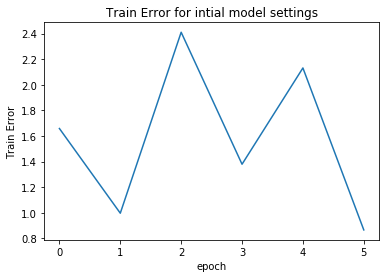

In [55]:
#plotting the training error of the model:
plt.plot(model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title('Train Error for intial model settings')
plt.show()

##Hyperparameter Tuning:

In [65]:
#Comparing Adam with RMSProp
models = []
methods = ["Adam","RMSprop"]

In [67]:
for method in methods:
    model = DNWNet( wide_dim,embeddings_input,continuous_cols,deep_column_ind,
                      hidden_layers,dropout,encoding_dict,n_class)
    model.compile(optimizer=method)
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=5, batch_size=40)
    models.append(model)

Epoch 1 of 5, Loss: 1.743
Epoch 2 of 5, Loss: 1.602
Epoch 3 of 5, Loss: 1.816
Epoch 4 of 5, Loss: 1.355
Epoch 5 of 5, Loss: 1.785
Epoch 1 of 5, Loss: 1.927
Epoch 2 of 5, Loss: 30.55
Epoch 3 of 5, Loss: 96.975
Epoch 4 of 5, Loss: 4.795
Epoch 5 of 5, Loss: 2.106


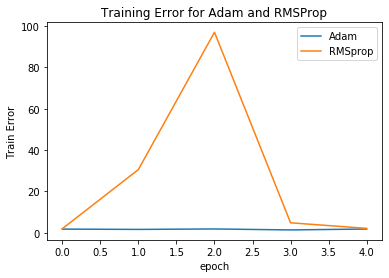

In [72]:
for model in models:
    plt.plot(np.arange(5),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(methods, loc='upper right')
plt.title("Training Error for Adam and RMSProp")
plt.show()

In [69]:
for model in models:
    print("for "+ str(model.optimizer))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
test mean squared error: 1.3483741350618021
test mean absolute error: 0.9023418351189219
for RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
test mean squared error: 2.493550604484618
test mean absolute error: 1.2355311263289825


In [78]:
#Optimizing dropout values
dropouts = [0,0.1,0.3,0.6,0.7,1]
models_dropout = []

In [79]:
for drop in dropouts:
    dropout = [drop,drop]
    model = DNWNet( wide_dim, embeddings_input, continuous_cols,
                      deep_column_ind, hidden_layers, dropout, encoding_dict,
                      n_class)
    model.compile(optimizer="Adam")
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=3, batch_size=40)
    models_dropout.append(model)

Epoch 1 of 3, Loss: 1.152
Epoch 2 of 3, Loss: 1.332
Epoch 3 of 3, Loss: 0.818
Epoch 1 of 3, Loss: 1.487
Epoch 2 of 3, Loss: 1.677
Epoch 3 of 3, Loss: 1.196
Epoch 1 of 3, Loss: 1.747
Epoch 2 of 3, Loss: 1.528
Epoch 3 of 3, Loss: 1.265
Epoch 1 of 3, Loss: 1.658
Epoch 2 of 3, Loss: 0.926
Epoch 3 of 3, Loss: 1.649
Epoch 1 of 3, Loss: 1.142
Epoch 2 of 3, Loss: 3.459
Epoch 3 of 3, Loss: 1.822
Epoch 1 of 3, Loss: 1.601
Epoch 2 of 3, Loss: 1.859
Epoch 3 of 3, Loss: 0.964


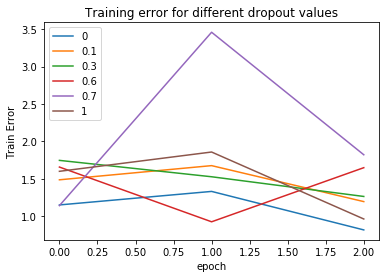

In [82]:
for model in models_dropout:
    plt.plot(np.arange(3),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(droupouts, loc='upper left')
plt.title("Training error for different dropout values")
plt.show()

In [112]:
for model in models_dropout:
    print("for dropouts: "+ str(model.dropout))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for dropouts: [0, 0]
test mean squared error: 1.2648771905187544
test mean absolute error: 0.9515922579944239
for dropouts: [0.1, 0.1]
test mean squared error: 1.4516496061966817
test mean absolute error: 1.005462791789853
for dropouts: [0.3, 0.3]
test mean squared error: 1.282016061451221
test mean absolute error: 0.933543559364026
for dropouts: [0.6, 0.6]
test mean squared error: 1.6113981780118918
test mean absolute error: 0.9676427772878051
for dropouts: [0.7, 0.7]
test mean squared error: 1.397625587399844
test mean absolute error: 0.9123627331506017
for dropouts: [1, 1]
test mean squared error: 1.3116251071739726
test mean absolute error: 0.9302601805100777


In [83]:
%%time
dropout = [0.7,0.7]
model = DNWNet(wide_dim, embeddings_input, continuous_cols, deep_column_ind,
              hidden_layers,dropout,encoding_dict,n_class)
model.compile(optimizer = 'Adam')
if use_cuda:
    model = model.cuda()
model.fit(dataset = train_dataset, n_epochs = 10, batch_size = 70)

Epoch 1 of 10, Loss: 1.961
Epoch 2 of 10, Loss: 1.492
Epoch 3 of 10, Loss: 2.455
Epoch 4 of 10, Loss: 0.757
Epoch 5 of 10, Loss: 1.018
Epoch 6 of 10, Loss: 1.315
Epoch 7 of 10, Loss: 0.683
Epoch 8 of 10, Loss: 0.9
Epoch 9 of 10, Loss: 0.594
Epoch 10 of 10, Loss: 0.642
Wall time: 2h 24min 58s


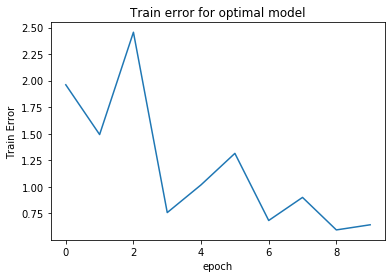

In [87]:
plt.plot(np.arange(10),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title('Train error for optimal model')
plt.show()

In [88]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 2.5401197644466222
test mean absolute error: 1.2535699011430814


In [90]:
%%time
#Training for 20 epochs:
dropout = [0.7,0.7]
model = DNWNet(wide_dim, embeddings_input, continuous_cols, deep_column_ind,
              hidden_layers,dropout,encoding_dict,n_class)
model.compile(optimizer = 'Adam')
if use_cuda:
    model = model.cuda()
model.fit(dataset = train_dataset, n_epochs = 20, batch_size = 70)

Epoch 1 of 20, Loss: 1.133
Epoch 2 of 20, Loss: 0.915
Epoch 3 of 20, Loss: 1.203
Epoch 4 of 20, Loss: 2.078
Epoch 5 of 20, Loss: 1.264
Epoch 6 of 20, Loss: 1.696
Epoch 7 of 20, Loss: 1.248
Epoch 8 of 20, Loss: 0.264
Epoch 9 of 20, Loss: 0.648
Epoch 10 of 20, Loss: 2.192
Epoch 11 of 20, Loss: 1.966
Epoch 12 of 20, Loss: 0.599
Epoch 13 of 20, Loss: 0.505
Epoch 14 of 20, Loss: 0.927
Epoch 15 of 20, Loss: 2.235
Epoch 16 of 20, Loss: 2.596
Epoch 17 of 20, Loss: 0.55
Epoch 18 of 20, Loss: 0.446
Epoch 19 of 20, Loss: 1.018
Epoch 20 of 20, Loss: 0.946
Wall time: 26min 21s


In [91]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 1.2845704647381528
test mean absolute error: 0.9606604314382203


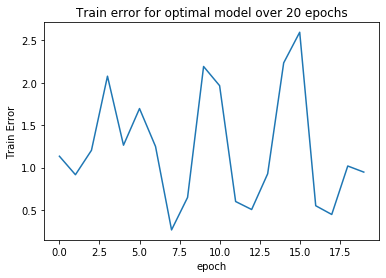

In [101]:
plt.plot(np.arange(20),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title('Train error for optimal model over 20 epochs')
plt.show()

In [113]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels

print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 1.3116251071739726
test mean absolute error: 0.9302601805100777


In [34]:
%%time
#Training for 20 epochs:
dropout = [0.7,0.7]
model = DNWNet(wide_dim, embeddings_input, continuous_cols, deep_column_ind,
              hidden_layers,dropout,encoding_dict,n_class)
model.compile(optimizer = 'Adam')
if use_cuda:
    model = model.cuda()
model.fit(dataset = train_dataset, n_epochs = 200, batch_size = 100)


Epoch 1 of 200, Loss: 1.215
Epoch 2 of 200, Loss: 1.145
Epoch 3 of 200, Loss: 1.416
Epoch 4 of 200, Loss: 1.108
Epoch 5 of 200, Loss: 1.016
Epoch 6 of 200, Loss: 0.994
Epoch 7 of 200, Loss: 1.588
Epoch 8 of 200, Loss: 1.059
Epoch 9 of 200, Loss: 2.315
Epoch 10 of 200, Loss: 1.681
Epoch 11 of 200, Loss: 1.812
Epoch 12 of 200, Loss: 1.317
Epoch 13 of 200, Loss: 1.262
Epoch 14 of 200, Loss: 1.615
Epoch 15 of 200, Loss: 1.579
Epoch 16 of 200, Loss: 1.494
Epoch 17 of 200, Loss: 1.2
Epoch 18 of 200, Loss: 1.134
Epoch 19 of 200, Loss: 1.209
Epoch 20 of 200, Loss: 1.844
Epoch 21 of 200, Loss: 1.26
Epoch 22 of 200, Loss: 1.321
Epoch 23 of 200, Loss: 1.199
Epoch 24 of 200, Loss: 1.318
Epoch 25 of 200, Loss: 1.964
Epoch 26 of 200, Loss: 1.381
Epoch 27 of 200, Loss: 1.072
Epoch 28 of 200, Loss: 1.579
Epoch 29 of 200, Loss: 1.476
Epoch 30 of 200, Loss: 1.817
Epoch 31 of 200, Loss: 2.848
Epoch 32 of 200, Loss: 1.438
Epoch 33 of 200, Loss: 1.477
Epoch 34 of 200, Loss: 1.79
Epoch 35 of 200, Loss: 1.52

In [36]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 1.461854552437191
test mean absolute error: 1.00837948812358


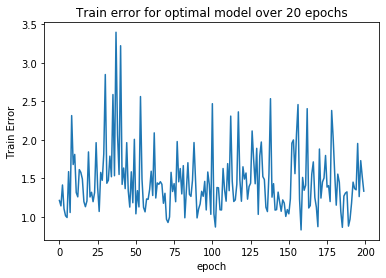

In [38]:
plt.plot(np.arange(200),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title('Train error for optimal model over 20 epochs')
plt.show()

In [39]:
%%time
#Training for 20 epochs:
dropout = [0.7,0.7]
model = DNWNet(wide_dim, embeddings_input, continuous_cols, deep_column_ind,
              hidden_layers,dropout,encoding_dict,n_class)
model.compile(optimizer = 'Adam')
if use_cuda:
    model = model.cuda()
model.fit(dataset = train_dataset, n_epochs = 20, batch_size = 10000)

Epoch 1 of 20, Loss: 2062.737
Epoch 2 of 20, Loss: 454.558
Epoch 3 of 20, Loss: 110.84
Epoch 4 of 20, Loss: 23.721
Epoch 5 of 20, Loss: 5.86
Epoch 6 of 20, Loss: 2.606
Epoch 7 of 20, Loss: 1.593
Epoch 8 of 20, Loss: 1.302
Epoch 9 of 20, Loss: 1.567
Epoch 10 of 20, Loss: 1.426
Epoch 11 of 20, Loss: 1.292
Epoch 12 of 20, Loss: 1.132
Epoch 13 of 20, Loss: 1.246
Epoch 14 of 20, Loss: 1.35
Epoch 15 of 20, Loss: 1.455
Epoch 16 of 20, Loss: 1.294
Epoch 17 of 20, Loss: 1.522
Epoch 18 of 20, Loss: 1.349
Epoch 19 of 20, Loss: 1.02
Epoch 20 of 20, Loss: 1.362
Wall time: 3min 52s


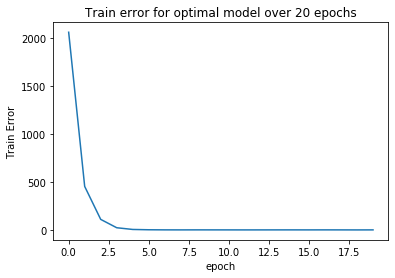

In [40]:
plt.plot(np.arange(20),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title('Train error for optimal model over 20 epochs')
plt.show()